<a href="https://colab.research.google.com/github/Maxouuu4/test_git/blob/main/math0487_nb7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 7 : **Tests d'hypothèse**

## Objectifs 🎯

Les objectifs de ce notebook sont les suivants :
- _comprendre_ le concept de test d'hypothèse et comment il est défini,
- _savoir appliquer_ la procédure de construction d'un test et _savoir l'utiliser_,
- _comprendre_ les notions de statistique de test, puissance, taille de test, et valeur critique,
- être capable de _construire_ une statistique de test pour tester des hypothèses données, et explorer différents types de tests,
- _comprendre_ la dualité entre tests d'hypothèse et intervalles de confiance,
- _comprendre_ la notion de _p-value_ et savoir repérer le _p-hacking_.


## Contexte 🔍

Dans ce septième notebook, nous allons aborder différents concepts liés aux tests d'hypothèse. À nouveau, par commodité, nous allons travailler avec des données synthétiques, mais les tests d'hypothèses sont bien sûr des procédures utilisées dans de nombreux domaines et industries avec des données réelles.

Commençons par importer les librairies dont nous aurons besoin. 👇

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, t, ttest_ind
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.patches import Patch, Rectangle
from ipywidgets import interact

## Tests d'hypothèse : de quoi parle-t-on ? 🤔

Jusqu'à présent, nous nous sommes principalement intéressés à un type de tâche en statistiques, _i.e._ modéliser un processus générateur de données et estimer ses paramètres, au travers de trois méthodes aux principes et portées différents :
- l'estimation ponctuelle,
- l'estimation par intervalles,
- la régression linaire.

Cependant, dans de nombreux cas en statistiques appliquées, que cela soit dans le domaine de la technologie (ingénieurie, finance, biotechnologies, etc.), en recherche, ou dans le conseil de politiques publiques, la tâche qui nous intéresse va plus loin que cette étape de modélisation et consiste à **prendre des décisions** basées sur les **données**.

👉 Nous allons à travers ce notebook explorer un cadre de travail permettant de s'attaquer à cette tâche : les **tests d'hypothèse**.

Le principe est simple :

1️⃣ On va postuler une hypothèse dite _nulle_, notée $H_0$, correspondant au _status quo_, et une hypothèse dite _alternative_, notée $H_1$, correspondant au cas le plus intéressant ou surprenant, en fonction du contexte.

Par exemple, vous travaillez pour une entreprise possédant un site de vente en ligne. Á la suite d'une modification de l'interface du site et de l'ajout de nouvelles fonctionnalités (probablement vendues comme _AI-Powered_), l'entreprise aimerait savoir si cet investissement a eu un effet positif significatif sur ses ventes. Autrement dit, il s'agit, à partir de données récoltées récemment, de tester l'hypothèse $H_1$ "les ventes ont augmenté" contre le _status quo_, l' "indifférence", $H_0$ "les ventes n'ont pas augmenté (ou ont diminué)".  

> ⚠️ $H_1$ ne correspond pas forcément à une hypothèse "désirée" pour le testeur. Par exemple, si vous travaillez dans le contrôle qualité d'une entreprise fabriquant des pièces mécaniques, et que vous devez tester l'hypothèse selon laquelle, à cause de l'usure des machines par exemple, le diamètre d'une pièce circulaire ne respecte plus certaines tolérances, le _status quo_ est que rien n'a changé, tandis que l'hypothèse alternative est que le diamètre a changé (ce qui n'est pas désiré).


2️⃣ On va construire une _statistique de test_ $\:T(\mathbf{Y})$, c'est-à-dire une statistique (⚠️ dont on peut calculer la réalisation à partir de l'échantillon $\mathbf{y}$, comme $\bar{Y}$, $S$, $\frac{\bar{Y} - 4}{1/\sqrt{n}}$, etc, **ce n'est donc pas un pivot**), et déterminer un critère $c$ auquel confronter cette statistique. Nous verrons comment déterminer ce critère pour assurer une certaine robustesse au test.

3️⃣ On comparera enfin la valeur de la statistique $T(\mathbf{y})$, pour l'échantillon $\mathbf{y}$ que l'on considère, avec le critère $c$, afin de déterminer si les données permettent de _rejeter_ l'hypothèse nulle, ou ne permettent _pas_ de _rejeter_ celle-ci.

Cette dernière étape constitue bien une prise de _décision_ sur base de _données_ récoltées.

Illustrons ce principe de décision. 👀


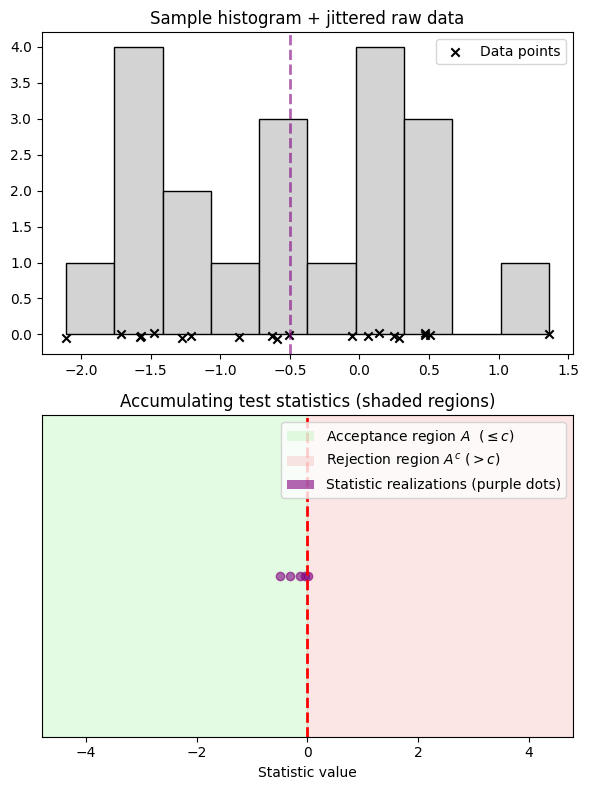

Dropdown(description='Statistic:', options=('mean', 'std', 'pivot'), value='mean')

IntSlider(value=20, description='n:', max=200, min=5)

FloatSlider(value=0.0, description='c:', max=5.0, min=-5.0)

Button(description='Generate sample & update plots', style=ButtonStyle())

In [ ]:
stat_history = []
last_sample = None
last_stat = None

def reset_history(change):
    global stat_history, last_sample, last_stat
    stat_history = []
    last_sample = None
    last_stat = None

# Widgets
statistic_choice = widgets.Dropdown(
    options=['mean', 'std', 'pivot'],
    value='mean',
    description='Statistic:'
)

sample_size_slider = widgets.IntSlider(
    value=20, min=5, max=200, step=1, description='n:'
)

critical_value_slider = widgets.FloatSlider(
    value=0.0, min=-5, max=5, step=0.1, description='c:'
)

button = widgets.Button(description="Generate sample & update plots")

# Attach resets
statistic_choice.observe(reset_history, names='value')
sample_size_slider.observe(reset_history, names='value')

# Statistic computation
def compute_stat(sample, stat_choice):
    if stat_choice == "mean":
        return np.mean(sample)
    elif stat_choice == "std":
        return np.std(sample, ddof=1)
    elif stat_choice == "pivot":
        return np.sqrt(len(sample)) * np.mean(sample)
    else:
        raise ValueError("Unknown statistic")

# Plot helper
def draw_plots(show_top=True):
    """
    Draws the top histogram (if show_top and last_sample exists) and
    always draws the second accumulating-statistic plot with shaded regions.
    """
    global stat_history, last_sample, last_stat

    clear_output(wait=True)

    if show_top and (last_sample is not None):
        fig, axes = plt.subplots(2, 1, figsize=(6, 8))
        ax_top, ax_bottom = axes
    else:
        fig, ax_bottom = plt.subplots(1, 1, figsize=(6, 3))
        ax_top = None

    # Histogram
    if ax_top is not None:
        sample = last_sample
        n = len(sample)
        ax_top.hist(sample, bins=10, color='lightgray', edgecolor='black')
        jitter = (np.random.rand(n) - 0.5) * 0.1
        scatter = ax_top.scatter(sample, np.zeros(n) + jitter - 0.02,
                                 marker='x', color='black', label="Data points")
        if last_stat is not None and statistic_choice.value == "mean":
            ax_top.axvline(last_stat, color='purple', linestyle='--', linewidth=2, alpha=0.6)
        ax_top.set_title("Sample histogram + jittered raw data")
        ax_top.legend()

    # Stats plot
    c = critical_value_slider.value
    stat_array = np.array(stat_history)

    if len(stat_array) > 0:
        x_min = min(stat_array.min(), -4.0)
        x_max = max(stat_array.max(), 4.0)
    elif last_stat is not None:
        x_min = min(last_stat, -4.0)
        x_max = max(last_stat, 4.0)
    else:
        x_min, x_max = -4.0, 4.0

    padding = 0.1 * (x_max - x_min) if (x_max - x_min) > 0 else 1.0
    x_left = x_min - padding
    x_right = x_max + padding

    ax = ax_bottom
    ax.clear()
    ax.set_xlim(x_left, x_right)

    # Shade regions
    ax.axvspan(x_left, c, color='lightgreen', alpha=0.25)
    ax.axvspan(c, x_right, color='lightcoral', alpha=0.2)

    ax.axvline(c, color='red', linestyle='--', linewidth=2)

    if len(stat_array) > 0:
        ax.scatter(stat_array, np.zeros_like(stat_array), color='purple', alpha=0.6)

    patch_accept = Patch(facecolor='lightgreen', edgecolor='none', alpha=0.25, label=r'Acceptance region $A$  ($\leq c$)')
    patch_reject = Patch(facecolor='lightcoral', edgecolor='none', alpha=0.2, label=r'Rejection region $A^c$ ($> c$)')
    dot_handle = Patch(facecolor='purple', edgecolor='none', alpha=0.6, label='Statistic realizations (purple dots)')
    ax.legend(handles=[patch_accept, patch_reject, dot_handle], loc='upper right')

    ax.set_yticks([])
    ax.set_xlabel("Statistic value")
    ax.set_title("Accumulating test statistics (shaded regions)")

    plt.tight_layout()
    plt.show()

    display(statistic_choice, sample_size_slider, critical_value_slider, button)

# Update function (c change)
def on_c_change(change):
    # redraw top if we have a last sample, otherwise only bottom
    draw_plots(show_top=(last_sample is not None))

critical_value_slider.observe(on_c_change, names='value')

# Update function (button)
def on_button_clicked(b):
    global stat_history, last_sample, last_stat

    n = sample_size_slider.value
    sample = np.random.randn(n)
    stat = compute_stat(sample, statistic_choice.value)

    last_sample = sample
    last_stat = stat
    stat_history.append(stat)

    draw_plots(show_top=True)

button.on_click(on_button_clicked)

# Initial display
draw_plots(show_top=False)


> ⚠️ Si l'on ne rejette pas $H_0$, cela ne signifie pas pour autant que cette hypothèse soit vraie. Cela signifie que _les données récoltées ne permettent pas de rejeter cette hypothèse_, mais peut-être est-ce simplement dû à de la malchance, à une construction de test bancale ou encore à une taille d'échantillon trop faible.

Bien, maintenant que le principe général est éclairci, voyons cela de manière plus formalisée. 👇

## Statistique de test et puissance 💪

Dans l'exemple introductif ci-dessus, nous avons proposé trois statistiques de test différentes, et avons joué avec la constante $c$.

🤔 Deux questions se posent cependant :
- Comment construit-on une statistique de test pour un test réel ? Que doit-on prendre en compte ? Quelle distribution a cette statistique, et est-ce utile de le savoir ?
- Comment détermine-t-on la constante $c$ ? Que prend-on en compte pour la déterminer, et peut-elle après tout prendre plusieurs valeurs ?

Et bien en fait, c'est assez simple, mais plusieurs choses sont à prendre en compte. Nous répondrons à la seconde question [plus loin](https://colab.research.google.com/drive/10WA-bLlHkXl7WOMS0v9ZyITvevkPjaz6#scrollTo=zFz6BUO_pRHI&line=9&uniqifier=1), intéressons-nous tout d'abord à la première. 👇

Nous faisons dans ce cours le choix de _définir_ la **région de rejet** associée à un test comme

$$A^c = \{\mathbf{y} : T(\mathbf{y}) > c\},$$

_i.e._ l'ensemble des données $\mathbf{y}$ qui mènent à une valeur de la statistique $T$ plus grande qu'une certaine valeur $c$, appelée **valeur critique**. C'est un choix arbitraire, nous aurions pu définir notre région en considérant les valeurs de $T$ plus petite que $c$, mais cela changerait alors la manière dont nous allons construire nos statistiques. Il est donc crucial de respecter cette définition, ainsi que d'en comprendre les implications.

Bien, nous voulons donc construire des statistiques $T$ qui prennent des valeurs plus importante si $H_0$ n'est pas vraie (car alors, si $H_0$ n'est pas vraie, nous avons plus de "chance" de tomber sur des données fournissant une valeur de $T$ "grande", et peut-être même plus grande que $c$, ce qui permet de rejeter $H_0$, et la boucle est bouclée).

Illustrons cela par un petit exemple. Pour tester l'hypothèse simple $H_1: \mu \neq \mu_0$ contre $H_0:\mu=\mu_0$, pour un échantillon $Y_1, \ldots, Y_n$ avec $Y_i \sim \mathcal{N}(\mu, \sigma^2)$, on peut par exemple définir la statistique de test $$T(\mathbf{Y}) = (\bar{Y} - \mu_0)^4 + (\bar{Y} - \mu_0)^2. $$  L'important ici est que cette statistique de test prend bien des **valeurs plus importantes sous $H_1$** que sous $H_0$ !

> Dans certains contextes, de telles statistiques "compliquées" conviennent bien pour décrire la quantité que l'on veut tester. Cependant, et comme nous le verrons plus tard, il est nécessaire de connaître la distribution de la statistique utilisée pour pouvoir déterminer la valeur critique $c$ !

Heureusement, notez que $T(\mathbf{Y})$ est une fonction strictement croissante de $$N(\mathbf{Y})=|\bar{Y} - \mu_0|,$$

et donc, rejeter $H_0$ pour de grandes valeurs de $T(\mathbf{Y})$ est équivalent à rejeter $H_0$ pour de grandes valeurs de $N(\mathbf{Y})$ ! La seule différence est évidemment la valeur critique $c$ à laquelle nous confronterons notre statistique. Il est ainsi souvent possible de déterminer un "morceau" de la statistique initiale qui reprend toute l'essence de celle-ci, mais qui est plus facile à manipuler, et dont la distribution peut aisément être déterminée.  

Sans nous soucier de comment $c$ est déterminé tant que maintenant (vous allez pouvoir choisir sa valeur), illustrons simplement comment une statistique de test prenant des valeurs plus importantes sous $H_1$ peut être utilisée pour tester une hypothèse. 👀

In [ ]:
# Widgets
mu_slider    = widgets.FloatSlider(value=0.0, min=-3, max=3, step=0.1, description="µ (truth)")
mu0_slider   = widgets.FloatSlider(value=0.0, min=-3, max=3, step=0.1, description="µ₀ (null)")
n_slider     = widgets.IntSlider(value=20, min=5, max=500, step=1, description="n")
sigma_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5, step=0.1, description="σ")
c_slider     = widgets.FloatSlider(value=4.0, min=0.1, max=50, step=0.1, description="c")

sample_button = widgets.Button(description="Sample", button_style="primary")

controls = widgets.VBox([
    widgets.HBox([mu_slider, mu0_slider]),
    widgets.HBox([n_slider, sigma_slider, c_slider]),
    sample_button
])

display(controls)

out = widgets.Output()
display(out)

rng = np.random.default_rng(12345)
state = {"sample": None, "ybar": None}

def compute_T_vals(ybar_vals, mu0, n, sigma):
    return n * (ybar_vals - mu0)**2 / (sigma**2)

def compute_N_vals(ybar_vals, mu0):
    return np.abs(ybar_vals - mu0)

# Draw function
def draw_figure():
    mu = mu_slider.value
    mu0 = mu0_slider.value
    n = n_slider.value
    sigma = sigma_slider.value
    c = c_slider.value

    if state["sample"] is None or len(state["sample"]) != n:
        state["sample"] = rng.normal(mu, sigma, size=n)
        state["ybar"] = state["sample"].mean()

    ybar = state["ybar"]

    xmin, xmax = mu0 - 4*sigma, mu0 + 4*sigma
    ybar_vals = np.linspace(xmin, xmax, 600)

    T_vals = compute_T_vals(ybar_vals, mu0, n, sigma)
    N_vals = compute_N_vals(ybar_vals, mu0)

    T_obs = n * (ybar - mu0)**2 / (sigma**2)
    N_obs = abs(ybar - mu0)

    # critical value for nugget from critical value for T
    Ncrit = np.sqrt(c * sigma**2 / n)

    with out:
        clear_output(wait=True)
        fig, (axT, axN) = plt.subplots(1,2, figsize=(13,5))

        # T plot
        axT.plot(ybar_vals, T_vals, lw=2, label=r"$t(y)$")
        axT.axhline(c, color='red', linestyle='--', label=fr"$T$ critical ({c:.2f})")
        axT.fill_between(ybar_vals, 0, c, color='green', alpha=0.15, label=r"$A$")
        axT.fill_between(ybar_vals, c, np.max(T_vals)*1.05, color='red', alpha=0.15, label=r"$A^c$")
        axT.scatter([ybar], [T_obs], color='purple', s=80, label=fr"observed $T={T_obs:.2f}$")
        axT.set_xlabel(r"$\bar{y}$"); axT.set_ylabel(r"$t(y) = n(\bar{y}−\mu_0)^2/\sigma^2$")
        axT.set_title(r"Complicated statistic $T(Y)$")
        axT.legend()

        # N plot
        axN.plot(ybar_vals, N_vals, lw=2, label=r"$n(y)$")
        axN.axhline(Ncrit, color='red', linestyle='--', label=fr"$N$ critical ({Ncrit:.2f})")
        axN.fill_between(ybar_vals, 0, Ncrit, color='green', alpha=0.15, label=r"$A$")
        axN.fill_between(ybar_vals, Ncrit, np.max(N_vals)*1.05, color='red', alpha=0.15, label=r"$A^c$")
        axN.scatter([ybar], [N_obs], color='purple', s=80, label=fr"observed $N={N_obs:.2f}$")
        axN.set_xlabel(r"${\bar{y}}$")
        axN.set_ylabel(r"$n(y) = | {\bar{y}}−\mu_0 | $")
        axN.set_title(r"Nugget $N(Y)$")
        axN.legend()

        plt.tight_layout()
        plt.show()

# Update function (general)
def on_any_change(change):
    # update figure (do not resample)
    if change['owner'] is n_slider:
        if state["sample"] is None or len(state["sample"]) != n_slider.value:
            state["sample"] = rng.normal(mu_slider.value, sigma_slider.value, size=n_slider.value)
            state["ybar"] = state["sample"].mean()
    draw_figure()

# Update function (sample)
def on_sample_click(_b):
    # draw a fresh sample from current mu, sigma, n
    state["sample"] = rng.normal(mu_slider.value, sigma_slider.value, size=n_slider.value)
    state["ybar"] = state["sample"].mean()
    draw_figure()

mu_slider.observe(on_any_change, names='value')
mu0_slider.observe(on_any_change, names='value')
n_slider.observe(on_any_change, names='value')
sigma_slider.observe(on_any_change, names='value')
c_slider.observe(on_any_change, names='value')

sample_button.on_click(on_sample_click)

# Initial display
draw_figure()


Output()

❓Quel effet à la valeur de $c$ sur la frontière entre la région de rejet et d'acceptation ? Quelle influence a cette valeur sur le taux de faux-positifs ?

❓Qu'observez-vous lorsque la vraie valeur de $\mu$ diffère fortement de la valeur de $\mu_0$ ?

> 🧠 Écrivez ici ce que vous en pensez !

Tout cela est évidemment valable pour des tests unilatéraux également, comme par exemple $H_0: \mu \leq \mu_0$ contre $H_1: \mu > \mu_0$. Dans ce cas, la statistique de test $$T(\mathbf{Y}) = \bar{Y} - \mu_0$$ fait tout à fait l'affaire. Voyons cela ensemble. 👀

In [ ]:
# Widgets
mu_slider    = widgets.FloatSlider(value=0.0, min=-3, max=3, step=0.1, description=r"µ (truth)")
mu0_slider   = widgets.FloatSlider(value=0.0, min=-3, max=3, step=0.1, description="µ₀ (null)")
n_slider     = widgets.IntSlider(value=20, min=5, max=500, step=1, description="n")
sigma_slider = widgets.FloatSlider(value=1.0, min=0.1, max=5, step=0.1, description="σ")
c_slider     = widgets.FloatSlider(value=0.5, min=-3, max=5, step=0.01, description="c")

sample_button = widgets.Button(description="Sample", button_style="primary")

controls = widgets.VBox([
    widgets.HBox([mu_slider, mu0_slider]),
    widgets.HBox([n_slider, sigma_slider, c_slider]),
    sample_button
])

display(controls)

out = widgets.Output()
display(out)

rng = np.random.default_rng(12345)
state = {"sample": None, "ybar": None}

def compute_stat_vals(ybar_vals, mu0):
    return ybar_vals - mu0  # one-sided statistic

def draw_figure():
    mu = mu_slider.value
    mu0 = mu0_slider.value
    n = n_slider.value
    sigma = sigma_slider.value
    c = c_slider.value

    # ensure we have a sample
    if state["sample"] is None or len(state["sample"]) != n:
        state["sample"] = rng.normal(mu, sigma, size=n)
        state["ybar"] = state["sample"].mean()

    ybar = state["ybar"]

    xmin, xmax = mu0 - 4*sigma, mu0 + 4*sigma
    ybar_vals = np.linspace(xmin, xmax, 600)

    stat_vals = compute_stat_vals(ybar_vals, mu0)
    stat_obs = ybar - mu0

    with out:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8,5))

        ax.plot(ybar_vals, stat_vals, lw=2, label=r"$\bar{y} - \mu_0$")
        ax.axhline(c, color='red', linestyle='--', label=f"critical value c = {c:.2f}")
        ax.fill_between(ybar_vals, -np.max(stat_vals)*1.05, c, color='green', alpha=0.15, label="Acceptance region")
        ax.fill_between(ybar_vals, c, np.max(stat_vals)*1.05, color='red', alpha=0.15, label="Rejection region")
        ax.scatter([ybar], [stat_obs], color='purple', s=80, label=f"observed value = {stat_obs:.2f}")

        ax.set_xlabel("ȳ")
        ax.set_ylabel(r"Statistic = $\bar{y} − \mu_0$")
        ax.set_title("Unilateral right-sided test")
        ax.legend()
        plt.show()

# Update function (general)
def on_any_change(change):
    if change['owner'] is n_slider:
        if state["sample"] is None or len(state["sample"]) != n_slider.value:
            state["sample"] = rng.normal(mu_slider.value, sigma_slider.value, size=n_slider.value)
            state["ybar"] = state["sample"].mean()
    draw_figure()

# Update function (sample)
def on_sample_click(_b):
    state["sample"] = rng.normal(mu_slider.value, sigma_slider.value, size=n_slider.value)
    state["ybar"] = state["sample"].mean()
    draw_figure()

mu_slider.observe(on_any_change, names='value')
mu0_slider.observe(on_any_change, names='value')
n_slider.observe(on_any_change, names='value')
sigma_slider.observe(on_any_change, names='value')
c_slider.observe(on_any_change, names='value')
sample_button.on_click(on_sample_click)

# Initial display
draw_figure()


Output()

❓Pourquoi la courbe bleue n'est-elle cette fois pas symétrique ?

> 🧠 Écrivez ici ce que vous en pensez !

Bien, concentrons-nous désormais sur la valeur critique à laquelle comparer notre statistique. Pour arriver à déterminer $c$, il nous faut introduire une notion importante : la **puissance d'un test**, notée $\beta(\theta)$, qui est une fonction simplement définie comme **la probabilité de rejeter $H_0$**, en fonction de la vraie valeur du paramètre qui nous intéresse, que nous appellerons $\theta$ : $$P(\text{rejeter $H_0$} \:|\: \theta) = P(T(\mathbf{Y}) > c \:|\: \theta).$$ La variable aléatoire ici est bien évidemment $\mathbf{Y}$.

Nous avons déjà pu avoir une idée de l'importance de cette _puissance_ puisque plus haut, nous avons intuitivement déterminé que notre but était bien évidemment que notre test rejette l'hypothèse nulle si celle-ci n'est pas vraie. Autrement dit, nous voulons un test _puissant_ pour toute valeur de $\theta$ qui n'est pas dans $\Theta_0$, l'ensemble des valeurs de $\theta$ telles que $H_0$ est vraie, _i.e._ nous voulons une grande _puissance_ quand la vraie valeur du paramètre ne correspond pas à $H_0$.

> Illustrons cela avec un petit exemple. 👇

Considérons à nouveau un échantillon _i.i.d._ $Y_1, \ldots, Y_n$ avec $Y_i\sim\mathcal{N}(\mu, \sigma^2)$ ($\sigma$ connu), les hypothèses composites $H_0: \mu \leq \mu_0$ et $H_1: \mu > \mu_0$, et la statistique $T=\bar{Y}-\mu_0$. La fonction de puissance est donnée par $$\beta(\mu) = P(T(\mathbf{Y}) > c \:|\: \mu) = P(\bar{Y}-\mu_0 > c \:|\: \mu).$$

_Quelle que soit la valeur de $\mu$_, $\bar{Y} \sim \mathcal{N}(\mu, \sigma^2/n)$ et donc $$T = \bar{Y} - \mu_0 \sim \mathcal{N}(\mu - \mu_0, \sigma^2/n).$$
On a dès lors que $$\begin{aligned}\beta(\mu) &= 1 - P\left(\bar{Y}-\mu_0 < c \:|\: \mu\right)\\&=1-P\left(\frac{(\bar{Y}-\mu_0) - (\mu - \mu_0)}{\sigma/\sqrt{n}} < \frac{c - (\mu - \mu_0)}{\sigma/\sqrt{n}}\right)\\&=1-Q_{\mathcal{N}(0, 1)}\left(\frac{c - (\mu - \mu_0)}{\sigma/\sqrt{n}}\right).\end{aligned}$$

> ⚠️ Nous avons pu déterminer $\beta(\mu)$ car nous connaissons la distribution de la statistique de test. Nous verrons que ce n'est pas toujours le cas et, s'il est parfois possible de se ramener à un "_nugget_" comme nous l'avons vu, le plus souvent ce sont les comportements asymptotiques qui arrivent à la rescousse.

Visualisons cette fonction de puissance pour plusieurs tailles d'échantillon $n$ ainsi que pour différentes valeurs critiques $c$. 👀



In [ ]:
mu0 = 0.0           # Null mean (boundary)
sigma = 1.0         # Known standard deviation
alpha = 0.05        # Test size
sample_sizes = [10, 30, 100, 500]
linestyles = ["-", ":", "-.", "--"]

# Widget
c_slider = widgets.FloatSlider(
    value=0.2, min=0., max=3.0, step=0.05,
    description="c", continuous_update=False
)

# Update function
def update_plot(c):
    theta = np.linspace(-1, 3, 400)

    plt.figure(figsize=(8, 6))

    for i, n in enumerate(sample_sizes):
        se = sigma / np.sqrt(n)

        # Power function
        power = 1 - norm.cdf((c - theta + mu0) / se)

        plt.plot(theta, power, label=f"n = {n}",
                 linewidth=2, linestyle=linestyles[i],
                 color="orange", alpha=0.6)

        plt.scatter([mu0], [alpha], s=60, color="black")

    plt.axvline(mu0, color="red", linestyle="--", linewidth=1.8,
                label=r"Boundary $\theta = \mu_0$")

    plt.axhline(alpha, color="black", linestyle=":", linewidth=1.8,
                label=fr"$\alpha$ = {alpha}")

    plt.title("Power Function of a One-Sided Test for the Mean")
    plt.xlabel(r"True Mean $\theta$")
    plt.ylabel("Power")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(alpha=0.2)

    plt.show()

# Display
widgets.interact(update_plot, c=c_slider)



interactive(children=(FloatSlider(value=0.2, continuous_update=False, description='c', max=3.0, step=0.05), Ou…

<function __main__.update_plot(c)>

❓Quelle est la différence entre $\theta_0$ et $\theta$, présentée comme la "True mean" ?

❓Pour une valeur de $n$ donnée, à quoi $c$ doit-il être égal pour que la courbe jaune associée passe par le point noir (l'intersection entre les pointillés noirs et les traitillés rouges) ?

❓Si, au lieu de $H_0: \mu \leq \mu_0$, nous avions postulé $H_0: \mu \geq \mu_0$, quel changement observerions-nous sur la figure ?

> 🧠 Écrivez ici ce que vous en pensez !

## Types d'erreur et taille de test 📏

Bien, maintenant que les notions de test et de puissance d'un test sont clarifiées, intéressons-nous à la procédure permettant de finir la construction de ces tests (on ne sait toujours pas vraiment comment fixer $c$ ou quelle statistique $T$ choisir 🤔).


Lorsque l'on teste une hypothèse, deux erreurs sont possibles :
- l'**erreur de Type I**, qui consiste à rejeter $H_0$ alors que celle-ci est vraie (ce qui correspond dans ce cas à un **faux-positif**),
- et **l'erreur de Type II**, qui consiste à ne pas rejeter $H_0$ alors que celle-ci est fausse (cela correspond alors à un **faux-négatif**).

Intuitivement, comme nous l'avons déjà exprimé, nous aimerions un test _puissant_ pour toute valeur du paramètre en dehors des valeurs postulées par l'hypothèse nulle, mais peu puissant pour ces dernières, _i.e_ ayant une probabilité de rejeter $H_0$ si elle est vraie assez faible ; autrement dit, menant à une faible erreur de Type I.  

Cela nous mène donc à la notion de _taille_ (ou _niveau_) d'un test, que l'on nomme $\alpha$, et qui est définie par $$\alpha = \max_{\theta \in \Theta_0} \beta(\theta),$$
_i.e._ la **probabilité maximale de réaliser une erreur de Type I**. Autrement dit, pour toutes les valeurs que peut prendre le paramètre qui nous intéresse sous $H_0$, cette taille représente le risque maximal de rejeter $H_0$.

Illustrons cela ensemble pour, à nouveau, un test unilatéral normal pour la moyenne, _i.e._ un test pour lequel on rejette $H_0$ si la statistique de la forme $\bar{Y} - \mu_0$ est plus grande que $c$. Dans ce cas, la fonction de puissance peut être déterminée comme nous l'avons fait plus haut, _puisque nous connaissons la distribution de notre statistique $T$_, et nous avons une taille $$\alpha = 1-Q_{\mathcal{N}(0, 1)}\left(\frac{c}{\sigma/\sqrt{n}}\right),$$ (voyez-vous pourquoi, en repartant de la fonction de puissance pour ce test que nous avons dérivée juste avant ?) et l'on voit bien que la limite $c$ et la taille $\alpha$ sont les deux revers d'une même médaille !

> N'hésitez-pas à revenir sur les figures précédentes, en pensant désormais au $\alpha$ qui se cache en fait derrière le $c$ que vous manipuliez !

Voyons l'influence de $c$ sur la _taille_ $\alpha$, pour ce test unilatéral. 👀

In [ ]:
mu0 = 0.0           # Null mean
sigma = 1.0         # Known standard deviation
theta = np.linspace(-1, 3, 400)   # Range of true means

# Widgets
n_slider = widgets.IntSlider(
    value=30, min=5, max=500, step=1,
    description="n", continuous_update=False
)

c1_slider = widgets.FloatSlider(
    value=0.5, min=0., max=3.0, step=0.05,
    description="c₁", continuous_update=False
)

c2_slider = widgets.FloatSlider(
    value=1.0, min=0., max=3.0, step=0.05,
    description="c₂", continuous_update=False
)

ui = widgets.VBox([n_slider, c1_slider, c2_slider])


# Update function
def update_plot(n, c1, c2):

    clear_output(wait=True)

    se = sigma / np.sqrt(n)

    # Power functions
    power1 = 1 - norm.cdf((mu0 + c1*se - theta) / se)
    power2 = 1 - norm.cdf((mu0 + c2*se - theta) / se)

    # Power under the null
    size1 = 1 - norm.cdf((mu0 + c1*se - mu0) / se)
    size2 = 1 - norm.cdf((mu0 + c2*se - mu0) / se)

    plt.figure(figsize=(8, 6))

    plt.plot(theta, power1, label=f"Test 1 (c = {c1})", linewidth=2, color="blue")
    plt.plot(theta, power2, label=f"Test 2 (c = {c2})", linewidth=2, color="green")

    plt.scatter([mu0], [size1], s=80, color="blue")
    plt.scatter([mu0], [size2], s=80, color="green")

    plt.axvline(mu0, color="red", linestyle="--", linewidth=1.5)

    plt.text(mu0+0.02, 1.02, r"$\theta_0$", color="red")

    plt.grid(alpha=0.25)

    plt.title("Comparison of Power Functions for Two One-Sided Mean Tests")
    plt.xlabel(r"True Mean $\theta$")
    plt.ylabel("Power")
    plt.ylim(0, 1.05)
    plt.legend()

    plt.annotate(f"size₁ = {size1:.3f}",
                 xy=(mu0, size1), xytext=(mu0+0.1, size1+0.1),
                 arrowprops=dict(arrowstyle="->", color="blue"),
                 color="blue")

    plt.annotate(f"size₂ = {size2:.3f}",
                 xy=(mu0, size2), xytext=(mu0+0.1, size2-0.1),
                 arrowprops=dict(arrowstyle="->", color="green"),
                 color="green")

    plt.show()


out = widgets.interactive_output(
    update_plot,
    {"n": n_slider, "c1": c1_slider, "c2": c2_slider}
)

# Display
display(ui, out)


Output()

❓Que représente $\theta_0$ ?

❓Qu'observez-vous comme influence de $c$ sur la taille du test $\alpha$ ? De faibles valeurs de $c$ correspondent-elles alors à des tests conservatifs ou non ?


> 🧠 Écrivez ici ce que vous en pensez !

Vérifions ensemble également, pour le même exemple, que la taille $\alpha$ est bien respectée si l'on simule des échantillons. 👀

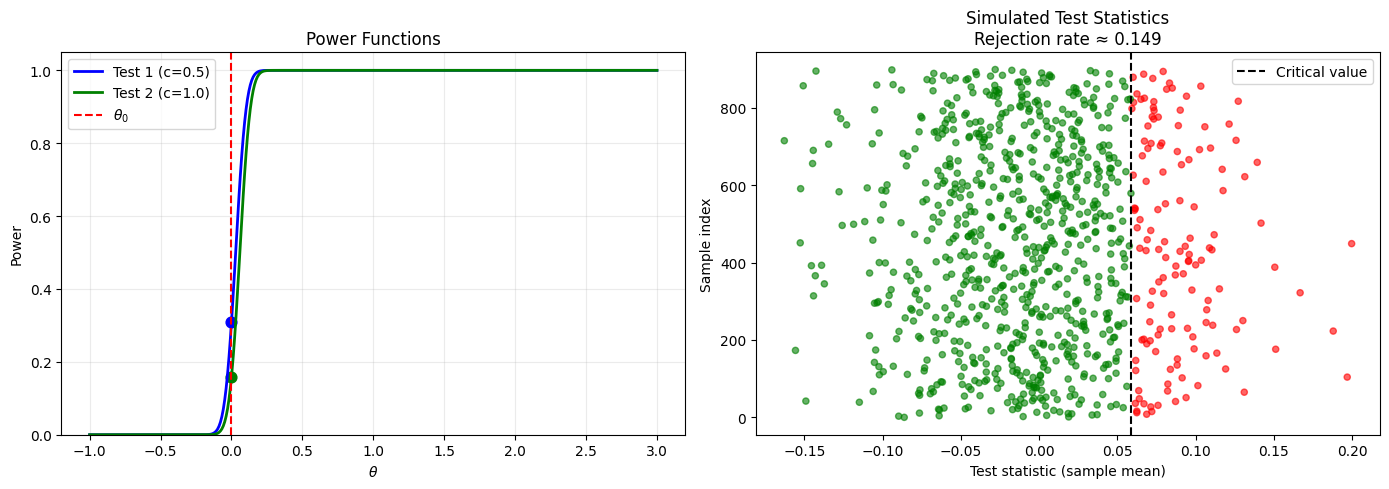

In [ ]:
# Parameters
mu0 = 0.0
sigma = 1.0
theta = np.linspace(-1, 3, 400)

# Widgets
n_slider = widgets.IntSlider(value=30, min=5, max=500, step=1,
                             description="n", continuous_update=False)

c1_slider = widgets.FloatSlider(value=0.5, min=0., max=3.0, step=0.05,
                                description="c₁", continuous_update=False)

c2_slider = widgets.FloatSlider(value=1.0, min=0., max=3.0, step=0.05,
                                description="c₂", continuous_update=False)

test_choice = widgets.Dropdown(
    options=[("Test 1 (c₁)", 1), ("Test 2 (c₂)", 2)],
    value=1, description="Test used:"
)

MC_slider = widgets.IntSlider(value=200, min=50, max=2000, step=50,
                              description="MC samples")

simulate_button = widgets.Button(description="Generate samples",
                                 button_style="danger")


left_box = widgets.VBox([n_slider, c1_slider, c2_slider, test_choice])
right_box = widgets.VBox([MC_slider, simulate_button])
ui = widgets.HBox([left_box, right_box])


# Update function (power)
def update_power_plot(n, c1, c2):
    se = sigma / np.sqrt(n)

    power1 = 1 - norm.cdf((mu0 + c1*se - theta) / se)
    power2 = 1 - norm.cdf((mu0 + c2*se - theta) / se)

    size1 = 1 - norm.cdf((mu0 + c1*se - mu0) / se)
    size2 = 1 - norm.cdf((mu0 + c2*se - mu0) / se)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax0 = ax[0]
    ax0.plot(theta, power1, label=f"Test 1 (c={c1})", color="blue", linewidth=2)
    ax0.plot(theta, power2, label=f"Test 2 (c={c2})", color="green", linewidth=2)

    ax0.scatter([mu0], [size1], s=60, color="blue")
    ax0.scatter([mu0], [size2], s=60, color="green")

    ax0.axvline(mu0, color="red", linestyle="--", label=r"$\theta_0$")
    ax0.grid(alpha=0.25)
    ax0.set_title("Power Functions")
    ax0.set_xlabel(r"$\theta$")
    ax0.set_ylabel("Power")
    ax0.set_ylim(0, 1.05)
    ax0.legend()

    return fig, ax


# MC simulation
def run_simulation(b):
    clear_output(wait=True)
    display(ui)

    n = n_slider.value
    MC = MC_slider.value
    c1 = c1_slider.value
    c2 = c2_slider.value
    chosen = test_choice.value

    c = c1 if chosen == 1 else c2
    se = sigma / np.sqrt(n)

    samples = np.random.randn(MC, n) * sigma + mu0
    means = samples.mean(axis=1)

    crit = mu0 + c * se
    rejects = means > crit
    rejection_rate = rejects.mean()

    fig, ax_pair = update_power_plot(n, c1, c2)

    ax1 = ax_pair[1]

    y_positions = np.arange(MC)

    ax1.scatter(means, y_positions,
                c=np.where(rejects, "red", "green"),
                alpha=0.6, s=20)

    ax1.axvline(crit, color="black", linestyle="--", label="Critical value")

    ax1.set_title(
        f"Simulated Test Statistics\nRejection rate ≈ {rejection_rate:.3f}"
    )
    ax1.set_xlabel("Test statistic (sample mean)")
    ax1.set_ylabel("Sample index")
    ax1.legend()

    plt.tight_layout()
    plt.show()

simulate_button.on_click(run_simulation)

# Display
display(ui)

❓Pour un test donné (le premier ou le second), comparez la taille $\alpha$ sur la figure de gauche (voyez-vous où y lire cette taille ?) et le _rejection rate_ de la figure de droite. Qu'observez-vous ? En serait-il de même si les données de cette seconde figure n'étaient pas générées en supposant $H_0$ vraie ?

> 🧠 Écrivez ici ce que vous en pensez !

> ⚠️ On parle depuis un certain temps de _taille de test_, et nous avons vu que, pour déterminer $c$ afin d'atteindre une taille $\alpha$ donnée, il nous fallait connaître la distribution de notre statistique de test $T$ !

Comme déjà mentionné plus haut, il est souvent possible de s'en sortir en considérant les comportements asymptotiques de nos tests. Par exemple, si la statistique de test considérée est **asymptotiquement** normale, on parlera alors du test associé (construit en considérant cette statistique comme normale) comme d'un test de taille **nominale** $1-\alpha$. Autrement dit, on a dans ce cas le comportement asymptotique $$\lim_{n\rightarrow \infty} \max_{\theta \in \Theta_0}P(T(\mathbf{Y}) > c \:|\: \theta) = \alpha,$$
qui veut simplement dire que la taille désirée n'est atteinte qu'asymptotiquement.

Illustrons cela en considérant un test bilatéral pour la moyenne ($H_0: \mu = \mu_0$) et la statistique de test $$T(\mathbf{Y}) = \sqrt{n}\frac{| \bar{Y} - \mu_0 |}{\hat{\sigma}}.$$
Asymptotiquement, sans faire d'hypothèse sur la distribution des variables aléatoires $Y_i$ qui composent l'échantillon $\mathbf{Y}$, $$\sqrt{n}\frac{\bar{Y} - \mu_0}{\hat{\sigma}} \overset{d}{\rightarrow}\mathcal{N}(0, 1),$$
_i.e._ la statistique (sans la valeur absolue) converge _en distribution_ (cela ne vous dit rien ? Retournez voir le notebook 3 😉) vers une loi normale standardisée.

Voyons ce que cela donne. 👀

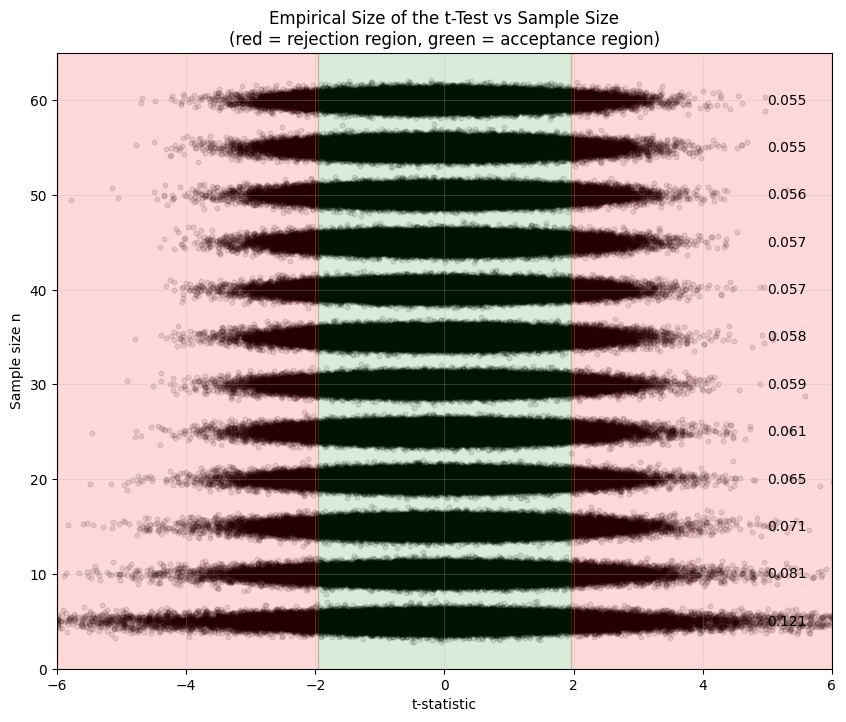

FloatSlider(value=0.05, continuous_update=False, description='α', max=0.2, min=0.001, readout_format='.3f', st…

IntSlider(value=100000, continuous_update=False, description='B samples', max=500000, min=10000, step=50)

Button(button_style='info', description='Generate', style=ButtonStyle())

In [ ]:
# Widgets
alpha_widget = widgets.FloatSlider(
    value=0.05, min=0.001, max=0.2, step=0.001,
    description="α", readout_format=".3f", continuous_update=False
)

B_widget = widgets.IntSlider(
    value=100_000, min=10_000, max=500_000, step=50,
    description="B samples", continuous_update=False
)

generate_button = widgets.Button(
    description="Generate", button_style="info"
)

# Default sample sizes
n_values = np.arange(5, 65, 5)

def run_simulation(*args):
    clear_output(wait=True)

    alpha = alpha_widget.value
    B = B_widget.value
    theta0 = 0.0  # null true mean
    sigma_true = 1.0

    fig, ax = plt.subplots(figsize=(10, 8))

    x_vals = np.linspace(-5, 5, 500)

    crit = norm.ppf(1 - alpha/2, loc=0, scale=1)

    for n in n_values:

        # Generate samples under H0
        data = np.random.normal(theta0, sigma_true, size=(B, n))
        means = data.mean(axis=1)
        sds = data.std(axis=1, ddof=1)
        t_stats = np.sqrt(n) * (means - theta0) / sds

        # Empirical size
        reject = np.abs(t_stats) > crit
        emp_size = reject.mean()

        # Scatter t-statistics horizontally at height = n
        ax.scatter(t_stats, np.full_like(t_stats, n) + np.random.normal(0, .5, size=len(t_stats)),
                   s=12, alpha=0.1, color="black")

        ax.text(5., n, f"{emp_size:.3f}", va='center')

    ax.fill_betweenx([-1, 200], -6, -crit,
                        color="red", alpha=0.15)
    ax.fill_betweenx([-1, 200], crit, 6,
                    color="red", alpha=0.15)
    ax.fill_betweenx([-1, 200], -crit, crit,
                    color="green", alpha=0.15)

    ax.set_title("Empirical Size of the t-Test vs Sample Size\n(red = rejection region, green = acceptance region)")
    ax.set_xlabel("t-statistic")
    ax.set_ylabel("Sample size n")
    ax.set_xlim(-6, 6)
    ax.set_ylim(min(n_values)-5, max(n_values)+5)
    ax.grid(alpha=0.25)

    plt.show()
    display(alpha_widget, B_widget, generate_button)

generate_button.on_click(run_simulation)

# Initial run
run_simulation()


❓Peut-on parler de _taille de test_ $\alpha$ ?

❓À partir de quelle taille d'échantillon diriez-vous que l'approximation est acceptable ? En est-il de même qu'importe la statistique de départ, pour autant que l'on connaisse une distribution asymptotique ?



> 🧠 Écrivez ici ce que vous en pensez !

## Différents tests et différentes statistiques 🔬

Bon, nous avons clarifié les différents concepts entourant les tests d'hypothèse, mais... nous n'avons testé que pour la moyenne.😅

Évidemment, les tests d'hypothèse ne se limitent pas qu'à cela, sinon cet outil serait ma foi fort limité !

Dans cette partie du notebook, nous allons explorer ensemble quatre catégories de test souvent rencontrées en pratique. Nous allons voir comment le problème se pose pour chacun avec un exemple concret, les hypothèses que l'on formule dans ce cas, la statistique de test que l'on définit et la distribution associée, ainsi que le critère de réjection qui en découle.👇


> ⚠️ Ces tests ne sont pas abordés dans les exercices vus au cours, et ne font par conséquent pas partie intégrante de la matière. Ils sont cependant importants afin d'avoir une idée plus précise d'applications concrètes du principe du test d'hypothèse.

Débutons avec un **test de corrélation entre deux variables**.

Une analyste travaillant dans la finance désire tester si les variations quotidiennes des écarts de crédit $X_i$ sont linéairement liées aux rendements des indices boursiers $Y_i$. Autrement dit, elle désire tester si le coefficient de corrélation linéaire entre ces deux variables $$\rho_{X, Y} = \frac{\operatorname{Cov}(X, Y)}{\sigma_X \sigma_Y}$$ est différent de zéro. Les hypothèses s'écrivent donc $$H_0:\; \rho_{X, Y} = 0, \;\;\; H_1:\; \rho_{X, Y} \neq 0. $$

On peut définir la statistique de test $$|T|=\left|r_{x, y}\sqrt{\frac{n−2}{1-r_{x, y}^2}}\right|​
​$$
où $$r_{x,y} \;\overset{\text{def}}{=}
\frac{\displaystyle \sum_{i=1}^n (X_i-\bar{X})(Y_i-\bar{Y})}{(n-1)S_x S_y}
\;=\;\frac{\displaystyle \sum_{i=1}^n (X_i-\bar{X})(Y_i-\bar{Y})}
{\sqrt{\displaystyle \sum_{i=1}^n (X_i-\bar{X})^2 \;\sum_{i=1}^n (Y_i-\bar{Y})^2}}$$ est un estimateur de $\rho_{X, Y}$.

🤔 Pas trop vite ! D'où sort cette statistique ?

Et bien, cette statistique, définie à l'aide du coefficient d'échantillon $r_{x, y}$, prend bien des valeurs plus importantes sous $H_1$ que sous $H_0$ :

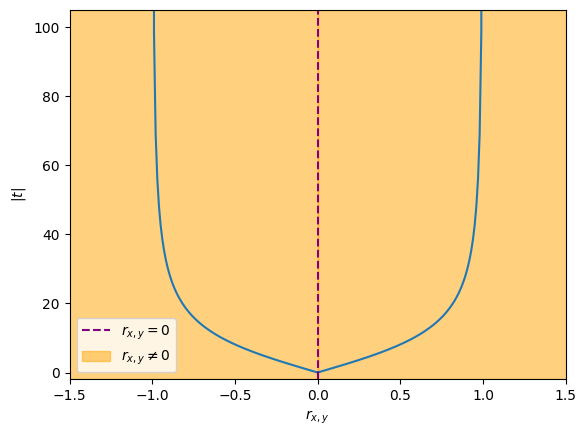

In [ ]:
rs = np.linspace(-1, 1, int(2 / 0.01))
ts = np.abs(rs * np.sqrt((len(rs) - 2) / ((1 - rs**2) + 10e-7)))

plt.plot(rs, ts)
plt.xlabel(r"$r_{x, y}$")
plt.ylabel(r"$|t|$")
plt.axvline(0, color="purple", linestyle="--", label=r"$r_{x, y} = 0$")
plt.fill_betweenx([-2, 105], [-2, -2], [-1e-5, -1e-5], alpha=0.5, color="orange", label=r"$r_{x, y} \neq 0$")
plt.fill_betweenx([-2, 105], [2, 2], [1e-5, 1e-5], alpha=0.5, color="orange")

plt.ylim(-2, 105)
plt.xlim(-1.5, 1.5)
plt.legend();

... et, sous $H_0$, et si les variables $X$ et $Y$ suivent une loi normale bivariée (en gros, une loi normale à deux dimensions), [on sait que](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Testing_using_Student's_t-distribution) $$T \sim t_{n-2}.$$

Dès lors, d'une manière similaire à ce qui a été fait plus haut ou en séances d'exercices, on sait que l'on peut tester nos hypothèse à l'aide du critère suivant : $$\mathbf{y} \in A^c \;\;\text{ si }\;\; t>t_{n-2}(1-\alpha/2) \;\;\text{ ou }\;\; t<t_{n-2}(\alpha/2), $$ autrement dit $$\mathbf{y} \in A^c \;\;\text{si}\;\; |t|>t_{n-2}(1-\alpha/2)$$ pour reprendre notre statistique de départ.

Illustrons ce premier exemple ensemble. 👀

In [ ]:
# Parameters
n = 50          # sample size
m = 10_000      # number of Monte Carlo simulations
df = n - 2
rho_alt = 0.5   # correlation under H1

def simulate_tstats(truth):
    tstats = np.zeros(m)

    for i in range(m):
        if truth == "H0 (null true)":
            # Independent data
            X = np.random.normal(size=n)
            Y = np.random.normal(size=n)
        else:
            # Generate correlated Gaussian data with true rho = rho_alt
            cov = np.array([[1, rho_alt], [rho_alt, 1]])
            XY = np.random.multivariate_normal(mean=[0,0], cov=cov, size=n)
            X, Y = XY[:,0], XY[:,1]

        # correlation
        r = np.corrcoef(X, Y)[0,1]
        # t-statistic
        tstats[i] = r * np.sqrt(df / (1 - r**2))

    return tstats

def plot_corr(alpha=0.05, truth="H0 (null true)"):

    # simulate if needed
    tstats = simulate_tstats(truth)

    # critical value
    t_crit = t.ppf(1 - alpha/2, df)
    rejs = np.abs(tstats) > t_crit

    fig, ax = plt.subplots(1,2, figsize=(16,5))

    ax[0].hist(tstats, bins=50, density=True, alpha=0.6, edgecolor='black')
    ax[0].axvline(t_crit, color='red', linestyle='--', lw=2)
    ax[0].axvline(-t_crit, color='red', linestyle='--', lw=2)
    ax[0].set_title(f"Correlation Test — {truth},  α={alpha}")
    ax[0].set_xlabel("t-statistic")

    y_jitter = 0.1*np.random.randn(m)
    ax[1].scatter(tstats, y_jitter, c=rejs, cmap='coolwarm', alpha=0.5, s=10)
    ax[1].axvline(t_crit, color='black', linestyle='--')
    ax[1].axvline(-t_crit, color='black', linestyle='--')
    ax[1].set_title("Rejections (red) vs Acceptances (blue)")
    ax[1].set_yticks([])
    ax[1].set_xlabel('t-statistic')

    plt.show()

    if truth == "H0 (null true)":
        print(f"Empirical Type I error: {rejs.mean():.4f} (target ≈ {alpha})")
    else:
        print(f"Empirical Power: {rejs.mean():.4f}")

# Widgets
interact(
    plot_corr,
    alpha=widgets.FloatSlider(
        value=0.05, min=0.001, max=0.2, step=0.001,
        description='alpha:', readout_format='.3f',
        continuous_update=False
    ),
    truth=widgets.Dropdown(
        options=["H0 (null true)", "H1 (alternative true)"],
        value="H0 (null true)",
        description="Truth:"
    )
)


interactive(children=(FloatSlider(value=0.05, continuous_update=False, description='alpha:', max=0.2, min=0.00…

<function __main__.plot_corr(alpha=0.05, truth='H0 (null true)')>

❓À quoi correspondent les lignes en traitillé rouge de la figure de gauche ?

❓À quoi correspond un point de la figure de droite ? Et les traitillés noirs ?

> 🧠 Écrivez ici ce que vous en pensez !

Voyons maintenant un second type de test très utilisé en pratique : le **test A/B**, ou **test sur deux échantillons**.

Ce type de test cherche à déterminer si la moyenne associée à une variable est différente d'un groupe à un autre. Par exemple, pour déterminer si le temps moyen passé sur ce notebook est différent chez les étudiants ayant assisté aux cours théoriques et ceux n'y ayant pas assisté. 😉

Considérons une étude clinique réalisée au sein d'une entreprise pharmaceutique à propos d'un nouveau médicament censé réduire la pression artérielle moyenne $\mu$ après une semaine de traitement. Deux groupes se voient donc administrer durant une semaine un traitement selon :
- groupe A : le médicament,
- groupe B : un placebo.

Les hypothèses à tester peuvent donc s'écrire dans ce cas $$H_0:\; \mu_A = \mu_B, \;\;\; H_1:\; \mu_A < \mu_B, $$ ou encore $$H_0:\; \mu_A - \mu_B = 0, \;\;\; H_1:\; \mu_A - \mu_B < 0.$$


Ceci est un exemple d'hypothèses qui font certes sens d'un point de vue pratique, mais qui ne couvrent pas toute une partie des valeurs de $\mu_A - \mu_b$ (la partie $\mu_A - \mu_B > 0$). On écrira donc $$H_0:\; \mu_A - \mu_B \geq 0, \;\;\; H_1:\; \mu_A - \mu_B < 0,$$ en sachant que $$\max_{\theta \in \Theta_0} \beta(\theta) = \max_{\mu_A - \mu_B \geq 0} \beta(\mu_A - \mu_B)$$ est atteint pour $\mu_A - \mu_B = 0$.

Si l'on considère que la pression artérielle montre la même variance quel que soit le groupe (A ou B), on peut construire la statistique de test $$T = -\frac{\bar{X} - \bar{Y}}{S_p \sqrt{\frac{1}{n_a} + \frac{1}{n_b}}}$$ où $$S_p^2 = \frac{(n_a - 1)S^2_X + (n_b -1)S^2_Y}{n_a + n_b -2},$$ avec $X$ représentant la pression artérielle chez un invidu du groupe A (dont l'échantillon contient $n_a$ éléments), $Y$ chez un individu du groupe B (dont l'échantillon contient $n_b$ éléments). À nouveau, cette statistique prend des valeurs plus élévées sous $H_1$, et on sait que, sous $H_0$ pour $\mu_A - \mu_B = 0$, $$T \sim t_{\nu}$$ avec $\nu = n_a + n_b - 2$.

À nouveau, on peut construire le critère suivant pour tester nos hypothèses : $$(\mathcal{x}, \mathcal{y}) \in A^c \;\;\text{ si } t > t_{n_a + n_b- 2}(1 - \alpha).$$

Voyons cela ensemble.👀

In [ ]:
# Parameters
n1, n2 = 50, 50
m = 10_000
df = n1 + n2 - 2
mu_diff_alt = 0.5  # true difference under H1

def simulate_ab(truth):
    """
    Simulate t-statistics for the A/B test under H0 or H1.
    """
    tstats = np.zeros(m)
    for i in range(m):

        if truth == "H0 (null true)":
            X = np.random.normal(0, 1, n1)
            Y = np.random.normal(0, 1, n2)

        else:  # H1
            X = np.random.normal(0, 1, n1)
            Y = np.random.normal(mu_diff_alt, 1, n2)

        # pooled variance
        s1 = X.var(ddof=1)
        s2 = Y.var(ddof=1)
        sp2 = ((n1-1)*s1 + (n2-1)*s2) / df

        # t statistic
        tstats[i] = (X.mean() - Y.mean()) / np.sqrt(sp2*(1/n1 + 1/n2))

    return tstats

# Update function
def plot_ab(alpha=0.05, truth="H0 (null true)"):

    tstats = simulate_ab(truth)
    t_crit = t.ppf(1 - alpha/2, df)
    rejs = np.abs(tstats) > t_crit

    fig, ax = plt.subplots(1,2, figsize=(16,5))

    ax[0].hist(tstats, bins=50, density=True, alpha=0.6, edgecolor='black')
    ax[0].axvline(t_crit, color='red', linestyle='--', lw=2)
    ax[0].axvline(-t_crit, color='red', linestyle='--', lw=2)
    ax[0].set_title(fr"A/B Test – {truth} – $\alpha$={alpha}")
    ax[0].set_xlabel("t-statistic")

    yjit = 0.1*np.random.randn(m)
    ax[1].scatter(tstats, yjit, c=rejs, cmap='coolwarm', alpha=0.5, s=10)
    ax[1].axvline(t_crit, color='black', linestyle='--')
    ax[1].axvline(-t_crit, color='black', linestyle='--')
    ax[1].set_title("Rejections (red) vs Acceptances (blue)")
    ax[1].set_yticks([])
    ax[1].set_xlabel("t-statistic")

    plt.show()

    if truth == "H0 (null true)":
        print(f"Type I error: {rejs.mean():.4f} (target ≈ {alpha})")
    else:
        print(f"Power: {rejs.mean():.4f}")

# Widgets
interact(
    plot_ab,
    alpha=widgets.FloatSlider(0.05, min=0.001, max=0.2, step=0.001, readout_format='.3f', description="alpha:"),
    truth=widgets.Dropdown(options=["H0 (null true)", "H1 (alternative true)"], value="H0 (null true)", description="Truth:")
)


interactive(children=(FloatSlider(value=0.05, description='alpha:', max=0.2, min=0.001, readout_format='.3f', …

<function __main__.plot_ab(alpha=0.05, truth='H0 (null true)')>

Un test peut également être utilisé pour juger de la qualité du _fit_ d'une distribution par un modèle. Il existe de nombreux tests rentrant dans cette catégorie, mais nous allons nous concentrer sur l'exemple classique du test du $\chi^2$ de Pearson, un test visant donc à évaluer la **_goodness of fit_ pour une variable _catégorique_**.

Supposons qu'une société de vente au détail prétende que ses ventes par catégorie de produit se distribuent comme

| Catégorie | Pourcentage |
| --- | --- |
| Électronique | 40% |
| Maison et cuisine | 20% |
| Jardin | 10% |
| Multimedia | 30% |

et que vous, analyste dans une boîte concurrente, désiriez tester si la distribution des préférences des clients suit en effet cette prétendue distribution multionomiale de probabilités $p_0 = (0.4, 0.2, 0.1, 0.3)$.

Les hypothèses s'écrivent cette fois :

$$ H_0: p=p_0, \; H_1: p\neq p_0, $$
ou de manière plus rigoureuse $H_1: p \in \{p \in [0, 1]^k : \sum_{i=1}^4p_i = 1\} \backslash \{p_0\}$.

On peut dans ce cas construire la statistique de test suivante $$T = \sum_{i=1}^{4}\frac{(Y_i - np_{0, i})^2}{np_{0, i}},$$
qui compile les différences entre effectifs attendus (le nombre d'achats de chaque catégorie selon les préférences prétendues $np_{0, i}$) et observés (les achats observés $Y_i$). Attention, l'indice $i$ représente l'indice d'une catégorie de produit, et $Y_i$ représente bien le nombre d'achats de cette catégorie au sein des individus constituant l'échantillon (dont le nombre n'est pas explicité ici).

Sous $H_0$,
$$T \;\dot\sim\; \chi^2_{k-1}$$ avec $k=4$ ici.

Vous noterez que c'est la première fois que nous rencontrons une statistique de test quadratique, mais la procédure reste la même et, à partir de $$P(T>c \:|\: p = p_0) = \alpha,$$ on peut construire le critère suivant : $$\mathbf{y}\in A^c \;\;\text{ si }\;\; t > \chi^2_{3}(1 - \alpha).$$

Voyons cela ensemble. 👀


In [ ]:
# Parameters
k = 6
n = 200
m = 10_000
df = k - 1

# Alternative distribution (skew)
p_alt = np.array([0.40, 0.12, 0.12, 0.12, 0.12, 0.12])

def simulate_gof(truth):
    stats = np.zeros(m)
    expected = np.ones(k) * (n / k)

    for i in range(m):
        if truth == "H0 (null true)":
            samples = np.random.choice(k, size=n)
        else:
            samples = np.random.choice(k, size=n, p=p_alt)

        obs = np.bincount(samples, minlength=k)
        stats[i] = np.sum((obs - expected)**2 / expected)

    return stats

# Update function
def plot_gof(alpha=0.05, truth="H0 (null true)"):

    stats = simulate_gof(truth)
    chi_crit = chi2.ppf(1 - alpha, df)
    rejs = stats > chi_crit

    fig, ax = plt.subplots(1,2, figsize=(16,5))

    ax[0].hist(stats, bins=50, density=True, alpha=0.6, edgecolor='black')
    ax[0].axvline(chi_crit, color='red', linestyle='--', lw=2)
    ax[0].set_title(fr"Chi-square GOF – {truth} – $\alpha={alpha}$")
    ax[0].set_xlabel("Test statistic")

    yjit = 0.1*np.random.randn(m)
    ax[1].scatter(stats, yjit, c=rejs, cmap='coolwarm', alpha=0.5, s=10)
    ax[1].axvline(chi_crit, color='black', linestyle='--')
    ax[1].set_title("Rejections (red) vs Acceptances (blue)")
    ax[1].set_yticks([])
    ax[1].set_xlabel("chi-square statistic")

    plt.show()

    if truth == "H0 (null true)":
        print(f"Type I error: {rejs.mean():.4f} (target ≈ {alpha})")
    else:
        print(f"Power: {rejs.mean():.4f}")

interact(
    plot_gof,
    alpha=widgets.FloatSlider(0.05, min=0.001, max=0.2, step=0.001, readout_format='.3f', description="alpha:"),
    truth=widgets.Dropdown(options=["H0 (null true)", "H1 (alternative true)"], value="H0 (null true)", description="Truth:")
)


interactive(children=(FloatSlider(value=0.05, description='alpha:', max=0.2, min=0.001, readout_format='.3f', …

<function __main__.plot_gof(alpha=0.05, truth='H0 (null true)')>

Il existe bien entendu une pléthore d'autres tests pour autant de cas d'usage. Nous n'en illustrerons pas d'autres dans ce notebook, mais sachez qu'ils suivent tous la même méthodologie que celles que nous avons utilisée jusqu'à présent. 😉

## Dualité tests d'hypothèse et intervalles de confiance 🤝

Bon, cela ne vous aura certainement pas échappé, la construction de certains test peut faire penser à la construction d'intervalles de confiance (voir le notebook 5).

En réalité, il existe une dualité entre les tests d'hypothèse et les intervalles de confiance ! Voyons cela plus en détails dans le cas d'une hypothèse nulle simple. 👇

Si l'on considère une hypothèse nulle simple $H_0=\theta_0$, et que l'on consdière la statistique de test $$T=\frac{\hat{\theta} - \theta_0}{\sigma} \sim \mathcal{N}(0, 1),$$ avec $\sigma$ connu, la région où l'on retient $H_0$ avec une taille de test $\alpha$ est donnée par $$T \in [Q_{\mathcal{N}(0, 1)}(\alpha/2), \: Q_{\mathcal{N}(0, 1)}(1 - \alpha/2)],$$ soit $$\hat{\theta} \in [\theta_0 + Q_{\mathcal{N}(0, 1)}(\alpha/2)\sigma, \: \theta_0 + Q_{\mathcal{N}(0, 1)}(1 - \alpha/2)\sigma].$$

> Tant que maintenant, rien de bien nouveau, c'est ce que l'on fait depuis le début de ce notebook.

Et bien en fait, l'intervalle de confiance au niveau $1-\alpha$ correspondant est donné par $$C(\mathbf{Y}) = [\hat{\theta} + Q_{\mathcal{N}(0, 1)}(\alpha/2)\sigma,\: \hat{\theta} + Q_{\mathcal{N}(0, 1)}(1-\alpha/2)\sigma].$$

> Mais qu'est-ce que cela veut dire, exactement ? 🤔

Simplement, que l'on peut réaliser le test d'hypothèse décrit ci-dessus à l'aide de l'intervalle de confiance ci-dessus, et que l'on peut construire un intervalle de confiance à l'aide du test !

Voyons premièrement comment nous pouvons **tester à l'aide de l'intervalle**.

> Pour un échantillon $\mathbf{y}$, à partir duquel on construit l'intervalle $C(\mathbf{y})$, si l'on retient $H_0$ si $\theta_0$ (postulé par... $H_0$) est inclus dans $C(\mathbf{y})$, cela revient à réaliser un test de taille $\alpha$ de l'hypothèse $H_0$. Autrement dit, si l'on réalise cette procédure pour beaucoup (tous, si possible...) d'échantillons $\mathbf{y}$, et que l'hypothèse $H_0$ est vraie, on devrait observer un taux de rejet de $H_0$ d'environ $\alpha$.

Voyons cela ensemble. 👀

In [ ]:
theta0 = 0
sigma = 1
n = 30
M = 1000  # number of displayed CI segments

def plot_CI_duality(alpha):

    z = norm.ppf(1 - alpha/2)

    ci_lows  = []
    ci_highs = []
    rejects  = []

    # simulate M datasets under H0
    for _ in range(M):
        X = np.random.normal(theta0, sigma, n)
        xbar = X.mean()
        CI_low  = xbar - z * sigma/np.sqrt(n)
        CI_high = xbar + z * sigma/np.sqrt(n)

        ci_lows.append(CI_low)
        ci_highs.append(CI_high)
        rejects.append(not (CI_low <= theta0 <= CI_high))

    reject_rate = np.mean(rejects)

    plt.figure(figsize=(10,10))

    first_color = ""
    second_color_label = False

    for i, (low, high, reject) in enumerate(zip(ci_lows, ci_highs, rejects)):
        color = "red" if reject else "green"
        if i == 0:
            first_color = color
        opacity = 1. if reject else .5

        if i == 0 or (first_color != color and not second_color_label):
          label = r"$\theta_0 \in\not C(\mathbf{y})$ ⇒ $H_0$ rejected" if reject else r"$\theta_0 \in C(\mathbf{y})$ ⇒ $H_0$ retained"
          plt.hlines(i, low, high, color=color, linewidth=2, alpha=opacity, label=label)
          if first_color != color:
            second_color_label = True
        else:
          plt.hlines(i, low, high, color=color, linewidth=2, alpha=opacity)

    plt.axvline(theta0, color="black", linestyle="--", linewidth=2, label=r"$\theta_0$")
    plt.title(fr"CI ⇒ Test duality   ($\alpha = {alpha:.3f}$)", fontsize=15)
    plt.xlabel(r"$\theta$")
    plt.ylabel("Simulation index")
    plt.legend()
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.show()

    print(r"Nominal α :", alpha)
    print("Empirical rejection rate =", reject_rate)

# Display
interact(plot_CI_duality,
         alpha=widgets.FloatSlider(value=0.05, min=0.001, max=0.2, step=0.005));


interactive(children=(FloatSlider(value=0.05, description='alpha', max=0.2, min=0.001, step=0.005), Output()),…

❓À quoi correspond chaque egment horizontal tracé ?

❓Comparez la valeur (nominale) de $\alpha$ et le taux de réjection (empirique) selon la méthode décrite plus haut. Cette méthode est elle donc valable ?

> 🧠 Écrivez ici ce que vous en pensez !

Bien, passons à la seconde partie de la dualité : comment utiliser un test pour obtenir un intervalle de confiance. 🤔

> Pour un échantillon $\mathbf{y}$, si l'on réalise le test de taille $\alpha$ décrit ci-dessus en considérant successivement chaque valeur de $\theta$ comme valeur de $\theta_0$, _i.e._ comme valeur du paramètre postulée selon $H_0$, et que l'on garde toutes les valeurs de $\theta$ pour lesquelles $H_0$ est retenue, cela revient en fait à construire un intervalle de confiance au niveau $1 - \alpha$ pour $\theta$ ! Autrement dit, si l'on réalise cette procédure pour un grand nombre d'échantillons, la proportion d'échantillons pour lesquels _l'ensemble des valeurs de $\theta$ telles que $H_0$ est retenue_ couvre la vraie valeur du paramètre sera de $1-\alpha$.

N'hésitez-pas à relire cette partie plusieurs fois, elle n'est pas toujours évidente à saisir du premier coup.😉 Voyons ensemble ce que cela donne en simulation. 👀

In [ ]:
sigma = 1
n = 30
theta_true = 1.2
M = 1000  # number of datasets

# theta0 grid
theta_grid = np.linspace(theta_true - 4, theta_true + 4, 600)

# Update function
def plot_test_inversion(alpha):

    zcrit = norm.ppf(1 - alpha/2)
    se = sigma / np.sqrt(n)

    CI_lows = []
    CI_highs = []

    for _ in range(M):
        # simulate dataset
        X = np.random.normal(theta_true, sigma, n)
        xbar = X.mean()

        # compute t-statistic for each theta0
        t_vals = (xbar - theta_grid) / se

        # acceptance region for this dataset
        accept = np.abs(t_vals) <= zcrit

        if not np.any(accept):
            # pathological case
            CI_lows.append(np.nan)
            CI_highs.append(np.nan)
        else:
            CI_lows.append(theta_grid[accept].min())
            CI_highs.append(theta_grid[accept].max())

    fig = plt.figure(figsize=(10,10))
    x_min, x_max = 0., 3.

    data_in_ar_cnter = 0

    for i, (low, high) in enumerate(zip(CI_lows, CI_highs)):
        if np.isnan(low):
            continue
        if i == 0:
          plt.hlines(i, low, high, color="green", linewidth=2, label=r"$C(\mathbf{y}) = \{\theta : \mathbf{y} \in A(\theta)\}$")
          plt.hlines(i, x_min, low, color="red", linewidth=1, alpha=.5, label=r"$\{\theta : \mathbf{y} \in\not A(\theta)\}$")
          plt.hlines(i, high, x_max, color="red", linewidth=1, alpha=.5)
        else:
          plt.hlines(i, low, high, color="green", linewidth=2)
          plt.hlines(i, x_min, low, color="red", linewidth=1, alpha=.5)
          plt.hlines(i, high, x_max, color="red", linewidth=1, alpha=.5)
        if low <= theta_true <= high:
            data_in_ar_cnter += 1

    plt.axvline(theta_true, color="black", linestyle="--", linewidth=2,
                label=r"$\theta$ (true)")

    plt.title(fr"Test ⇒ CI duality via test inversion ($\alpha={alpha:.3f}$)", fontsize=15)
    plt.xlabel(r"$\theta_0$")
    plt.ylabel("Dataset index")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.show()

    print(r"Nominal α:", alpha)
    print(f"Empirical coverage probability = {data_in_ar_cnter / M:.2f}")

interact(plot_test_inversion,
         alpha=widgets.FloatSlider(value=0.05, min=0.001, max=0.2, step=0.005));


interactive(children=(FloatSlider(value=0.05, description='alpha', max=0.2, min=0.001, step=0.005), Output()),…

❓Que représente chaque ligne horizontale sur la figure ? En particulier, que représentent, pour une ligne, les parties rouge et verte ?

❓Comparez la taille (nominale) $\alpha$ du test au taux de couverture empirique. Que représente ce taux ? Cela justifie-t-il la méthode décrite juste avant pour construire un intervalle de confiance ?

> 🧠 Écrivez ici ce que vous en pensez !

## Valeurs _p_ et _p-hacking_ 🤥

Nous voici arrivés à la dernière partie de ce notebook, courage ! 💪

Nous allons brièvement parler de la valeur _p_ (_p-value_ en anglais), une notion souvent utilisée pour mettre en évidence la significativité du résultat d'un test.

Cette _p-value_ est souvent présentée comme la "_probabilité d'observer un résultat aussi extrême que celui observé sous $H_0$_" :
$$p(\mathbf{y}) = P(T \geq t | H_0),$$ où $t$ est la valeur de la statistique de test $T$ observée pour un échantillon $\mathbf{y}$.

> ⚠️ Cette définition n'est valable que si l'on considère une hypothèse nulle $H_0$ simple (_i.e._ $\theta = \theta_0$) ! Sinon, _i.e._ si sous $H_0$ $\theta$ peut prendre plusieurs valeurs, le conditionnement perd son sens, et ne permet généralement pas de déterminer la distribution de $T$. Dès lors, il n'est pas possible d'évaluer la _p-value_ en utilisant la définition ci-dessus, et une définition plus générale est nécessaire.

Cette définition générale s'écrit $$p(\mathbf{y}) = \min\{\alpha : \mathbf{y} \in A^c_{\alpha}\},$$
c'est-à-dire la plus petite valeur de $\alpha$ telle que, pour l'échantillon considéré $\mathbf{y}$, l'hypothèse $H_0$ aurait été rejetée. En conséquence, une _p-value_ faible correspond à une valeur de la statistique de test telle qu'il faudrait très fortement abaisser le risque d'erreur de type I pour enfin accepter $H_0$.

Visualisons cela ensemble pour clarifier les choses. 👀


In [ ]:
mu0 = 0       # Null mean
sigma = 1     # Known variance
n = 50        # Sample size

last_stat = None

# Widgets
alpha_slider = widgets.FloatSlider(
    value=0.05, min=0.00001, max=0.2, step=0.00001,
    description='α', continuous_update=False, readout_format='.5f'
)

test_type = widgets.Dropdown(
    options=['two-sided', 'right-sided', 'left-sided'],
    value='two-sided',
    description='Test type',
)

mu1_slider = widgets.FloatSlider(
    value=0.5, min=-3, max=3, step=0.1,
    description='μ₁ (truth)',
    continuous_update=False
)

sample_button = widgets.Button(
    description="Sample",
    button_style='info'
)

output = widgets.Output()


def compute_p_value(stat, test_type):
    if test_type == 'two-sided':
        return 2 * (1 - norm.cdf(abs(stat)))
    elif test_type == 'right-sided':
        return 1 - norm.cdf(stat)
    else:
        return norm.cdf(stat)

# Update function
def update_plot(_, alpha, test_type, mu1):
    global last_stat

    with output:
        clear_output(wait=True)

        # Null distribution
        pdf_extrem = np.abs(last_stat) + 2.
        z = np.linspace(-pdf_extrem, pdf_extrem, 400)
        pdf = norm.pdf(z)

        # Critical values depending on test type
        if test_type == 'two-sided':
            cv_left = norm.ppf(alpha/2)
            cv_right = norm.ppf(1 - alpha/2)
            reject_region = (z <= cv_left) | (z >= cv_right)
            accept_region = (z > cv_left) & (z < cv_right)
        elif test_type == 'right-sided':
            cv_right = norm.ppf(1 - alpha)
            reject_region = z >= cv_right
            accept_region = z < cv_right
            cv_left = None
        else:  # left-sided
            cv_left = norm.ppf(alpha)
            reject_region = z <= cv_left
            accept_region = z > cv_left
            cv_right = None

        fig, ax = plt.subplots(figsize=(10,5))

        ax.fill_between(z, 0, pdf, where=accept_region, color='green', alpha=0.4)

        ax.fill_between(z, 0, pdf, where=reject_region, color='red', alpha=0.4)

        # Draw null density
        ax.plot(z, pdf, color='black')

        if cv_left is not None:
            ax.axvline(cv_left, color='red', linestyle='-', label="$c$")
        if cv_right is not None:
            ax.axvline(cv_right, color='red', linestyle='-')

        if last_stat is not None:
            pval = compute_p_value(last_stat, test_type)
            ax.axvline(last_stat, color='blue', linestyle='--', linewidth=2,
                       label=fr"$z = {last_stat:.3f}$ | p-value = {pval:.5f}")

        ax.set_title(fr"Null Distribution of $Z$ ($H_0$: $\mu = {mu0}$) - Sampling from $\mu_1 = {mu1}$")
        ax.set_xlabel("Z")
        ax.legend()
        plt.show()

# Update function (button)
def on_sample_click(button):
    global last_stat

    mu1 = mu1_slider.value
    x = np.random.normal(mu1, sigma, n)
    xbar = np.mean(x)

    last_stat = (xbar - mu0) / (sigma / np.sqrt(n))

    update_plot(None, alpha_slider.value, test_type.value, mu1)


sample_button.on_click(on_sample_click)
alpha_slider.observe(lambda change: update_plot(None, alpha_slider.value,
                                                test_type.value, mu1_slider.value),
                     names='value')
test_type.observe(lambda change: update_plot(None, alpha_slider.value,
                                             test_type.value, mu1_slider.value),
                  names='value')
mu1_slider.observe(lambda change: update_plot(None, alpha_slider.value,
                                              test_type.value, mu1_slider.value),
                  names='value')


# Initial display
display(widgets.VBox([alpha_slider, test_type, mu1_slider, sample_button]), output)
on_sample_click(None)
update_plot(None, alpha_slider.value, test_type.value, mu1_slider.value)


Output()

❓Pour un échantillon donné, comment faites-vous apparaître la valeur $p$ sur le graphe ci-dessus ?

❓Lorsque $\mu_1$ est fort éloigné de $\mu_0$, la valeur $p$ est-elle élevée ou faible ? Cela correspond-il à un résultat très ou peu significatif ?

> 🧠 Écrivez ici ce que vous en pensez !

Comme mentionné ci-dessus, la valeur _p_ est une "mesure" très souvent utilisée pour justifier que les résultats d'un test sont _significatifs_. Cela évite de plus de fixer une taille de test $\alpha$ à l'avance.

Cependant, comme tout outil de persuasion, cette valeur _p_ peut être, disons, manipulée. En réalité, il est possible de réaliser des expériences sans respecter certaines conditions de sorte que la fameuse valeur _p_ associée aux résultats de ces expérience flatte ceux-ci, alors qu'ils ne sont en réalité pas significatifs du tout ! 😲

La (mauvaise) idée est de [« ne publier que les compositions d'échantillon et les périodes d'observation favorables à l'hypothèse testée »](https://fr.wikipedia.org/wiki/Data_dredging), pour prouver à peu près n'importe quoi...
Imaginez les répercussions que cela pourrait avoir si l'on teste l'efficacité d'un médicament par exemple, puis que l'on "trafique" les résultats (de manière consciente ou non)... mieux vaut savoir faire les choses correctement... ou savoir détecter si d'autres ne font pas les choses correctement de leur côté !

Il existe de nombreuses façons d'ainsi produire des résultats _faussement_ significatifs. Pour terminer ce notebook, nous allons donc illustrer deux exemples d'un tel _p-hacking_. 👇

Le premier exemple concerne la collecte des données utilisées dans un test. En effet, au lieu de prévoir en amont la taille $n$ de l'échantillon que l'on va considérer, l'**"_arrêt optionnel_"** désigne une pratique où l’on analyse les données au fur et à mesure qu’elles arrivent, et où l’on décide d’arrêter l’expérience dès que le test statistique devient significatif.

> On collecte quelques données, on teste. Ce n'est pas significatif ? On ajoute quelques données de plus, et on reteste. Et on s’arrête dès que la valeur _p_ est plus petite qu'un certain seuil (souvent fixé à $0.05$).

Mais où est le problème ? 🤔
Et bien, même si l’effet réel est nul (_i.e._ les données sont ce qu'elles sont, et ne devraient pas mener à des résultats différents), répéter le test encore et encore augmente _artificiellement_ la probabilité de trouver par hasard une valeur _p_ significative ! Procéder ainsi revient en effet à réaliser non pas 1 test, mais de nombreux tests avant de "bien tomber" ! Or, si la probabilité de ne pas obtenir de résultat significatif pour un test est de $1-\alpha$, la probabilité d'en obtenir au moins un qui l'est après $k$ essais (indépendants, ce qui n'est pas le cas ici, mais vous avez l'idée 😉) est de $1-(1-\alpha)^k$ !


Illustrons cette manière (malhonnête) de procéder ensemble. Nous allons réaliser un test $t$ à deux échantillons, _i.e._ un test A/B que nous avons illustré plus haut pour tester $H_0: \mu_A = \mu_B$ contre $H_1: \mu_A \neq \mu_B$. Nous allons considérer que $H_0$ est en réalité vraie, et générer des échantillons à l'aide de la même distribution exactement pour les deux groupes A et B.

C'est ici que la "triche" entre en jeu : nous n'allons pas fixer une taille d'échantillon fixe, mais allons ajouter un élément à la fois dans notre échantillon, et calculer la valeur $p$ associée. Voyons cela de plus près. 👀

In [ ]:
sigma2 = 10
Nmax = 10_000
n_min = 5

# Widgets
run_button = widgets.Button(description="Run simulation", button_style='success')
reset_button = widgets.Button(description="Reset", button_style='warning')
out = widgets.Output()

def run_simulation(_):
    with out:
        clear_output(wait=True)

        # Draw fresh data
        X = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Nmax)
        Y = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Nmax)

        ns = np.arange(n_min, Nmax + 1)
        pvals = np.zeros_like(ns, dtype=float)

        # Compute p-values sequentially
        for i, n in enumerate(ns):
            _, p_val = ttest_ind(X[:n], Y[:n], equal_var=True)
            pvals[i] = p_val

        plt.figure(figsize=(12, 5))
        plt.plot(ns, pvals, lw=1)
        plt.axhline(0.05, color='red', linestyle='--', lw=2, label=r"$\alpha = 0.05$")

        # plt.ylim(0, 1)
        # plt.xscale('log')
        plt.xlabel("Sample size n (log scale)")
        plt.ylabel("p-value")
        plt.title("P-hacking Illustration: p-values as n grows (two identical distributions)")
        plt.legend()
        plt.grid(True, which="both", ls=":", alpha=0.4)
        plt.show()

run_button.on_click(run_simulation)
display(run_button)
display(out)


Button(button_style='success', description='Run simulation', style=ButtonStyle())

Output()

❓Avez-vous observé une valeur $p$ plus faible que $\alpha$ ? Si non, n'hésitez pas à relancer une simulation ! Si oui, qu'auriez-vous conclu si, en amont et sans tricher, vous aviez sélectionné $n$ égal à la taile qui a donné cette fameuse valeur $p$ $< 0.05$ ? Est-ce problématique, ou attendu ?

> 🧠 Écrivez ici ce que vous en pensez !

Bien, passons enfin à notre deuxième et dernier exemple de _p-hacking_. Parlons cette fois des "**corrélations fallacieuses**".

Une corrélation fallacieuse est une corrélation qui semble réelle, forte ou statistiquement significative, mais qui ne reflète en réalité... absolument aucune relation véritable, _causale_ ou non, entre les variables.

Ces corrélations fallacieuses apparaissent naturellement lorsque, par exemple, l'on teste énormément de paires de variables. Tester la corrélation de centaines ou milliers de couples de variables (nous avons abordé de tels tests plus haut dans ce notebook 👆), jusqu’à ce que l’un d’eux donne une valeur _p_ faible, produit forcément, par hasard, une corrélation “significative” mais, à nouveau, totalement _artificielle_.

Pour illustrer cela, je vous invite vraiment à visiter le site de Tyler Vigen, et plus particulièrement son projet [Spurious Correlations](https://www.tylervigen.com/spurious-correlations), qui compile une grande variété de telles corrélations fallacieuses.
>Comme vous le verrez, il n'est pas compliqué de trouver des corrélations significatives entre des variables qui n'ont évidemment aucun rapport ! Pour chacune, vous pouvez en savoir plus en cliquant sur "_View details about correlation #..._", notamment les détails sur les données et la rubrique expliquant pourquoi cela fonctionne ! En bonus, une explication artificielle générée par une IA "expliquant" pourquoi les variables sont corrélées avec un tel niveau de significativité !

Bonne lecture ! 📖




## Conclusions et pistes de réflexion 💭

Voilà, c'en est fini de ce septième notebook, félicitations ! 🎉🥳

Vous maîtrisez désormais le concept de test d'hypothèse, une procédure centrale en statistique inférentielle. Nous avons abordé ensemble non seulement les bases, mais également les notions de test asymptotique et de taille nominale, nous avons illustré différents types de tests, tous suivant le même canevas général, ainsi que la dualité entre les tests et les intervalles de confiance, pour finir avec la notion de _p-value_ et les dérives qui y sont liées (_p-hacking_).

Bien sûr, il existe de nombreux autres tests que nous n'avons pas abordés ici. L'important est de comprendre la structure de ces tests, la philosophie derrière. Celle-ci ne change pas fondamentalement d'un test à l'autre, mais le contexte, ce que l'on désire tester, ou encore les données à disposition et la façon dont elles ont été récoltées vont par contre modifier la manière dont le critère final est construit.

Il est important de noter également que nous n'avons abordé les tests que selon l'approche fréquentiste. Il est évidemment tout à fait possible de réaliser des tests d'hypothèse selon la philosophie bayésienne, comme nous l'avons vu en cours ! Ce genre de test n'aborde pas les choses de la même manière qu'en fréquentiste, et certains types d'hypothèses sont d'ailleurs à proscrire. Je vous invite à retourner jeter un oeil aux slides si cela ne vous dit plus rien. 😉

Enfin, bien que nous ayons mentionné les erreurs de Types I et II, et que nous nous soyons servis de la première pour définir la taille d'un test, nous n'avons cependant pas parlé de spécificité, de sensitivité, ou encore de courbe ROC, qui sont des concepts très proches et régulièrement utilisé pour comparer des tests ou déterminer leurs paramètres optimaux.

